In [1]:
# import packages
import pandas as pd
import numpy as np
import json 
import random
from sklearn.feature_extraction.text import CountVectorizer
import re
import math
from similarity.normalized_levenshtein import NormalizedLevenshtein
normalized_levenshtein = NormalizedLevenshtein()
from similarity.qgram import QGram
import copy
import string
from math import comb

In [2]:
# load data
f = open('TVs-all-merged.json')
data = json.load(f)
f.close()
data 
modelids = [item['modelID'] for sublist in data.values() for item in sublist]
shops = [item['shop'] for sublist in data.values() for item in sublist]
features = [item['featuresMap'] for sublist in data.values() for item in sublist]
# Get the titles and convert to lower case
titles = [item['title'] for sublist in data.values() for item in sublist]
titles = [s.lower() for s in titles]
pattern = re.compile(r'[- /]*((hz)|hertz)')
# Replace occurrences in each item
titles = [pattern.sub(r'hz', title) for title in titles]
# Define the pattern to match "-inch" or " inch"
pattern = re.compile(r'[- /]*((inch)|inches)')
# Replace occurrences in each item
titles = [pattern.sub(r'"', title) for title in titles]
pattern = re.compile(r'["]')
titles = [pattern.sub(r'inch ', title) for title in titles]
pattern = re.compile(r'(diagonal)+|(diagonally)')
titles = [pattern.sub(r'diag.', title) for title in titles]
pattern = re.compile(r'(newegg.com)|[-()/]|(thenerds.net)|(best)|(buy)|(refurbished)')
titles= [pattern.sub(r'', title) for title in titles]
titles = [title.replace('ledlcd', ' led lcd ') for title in titles]
pattern = re.compile(r'[^a-zA-Z0-9-]')
titles = [pattern.sub(r' ', title) for title in titles]


setShops = set(shops)
# Initialize an empty set to store unique brands
unique_brands = set()

# Iterate through each dictionary in the list
for product_info in features:
    # Check if the 'Brand' key is present in the dictionary
    if 'Brand' in product_info:
        # Add the brand to the set (case-insensitive)
        unique_brands.add(product_info['Brand'].lower())
unique_brands
brands = {'philips', 'azend','sharp', 'supersonic', 'sony', 'toshiba', 'tcl', 'samsung', 'sanyo', 'panasonic', 'vizio', 'coby', 
          'viewsonic', 'sunbritetv', 'westinghouse', 'epson', 'avue', 'insignia', 'jvc', 'nec', 'venturer', 'rca', 'hisense',
          'affinity', 'compaq', 'craig', 'elo', 'optoma', 'dynex', 'mitsubishi', 'contex', 'viore', 'hiteker', 'elite', 'gpx', 'curtisyoung', 'lg'}
test = unique_brands - brands
brands = brands.union((test))
brands = list(brands)
brands.remove('jvc tv')
brands.remove('lg electronics')
brands_list = [None]*len(titles)
count = -1
for title in titles:
    count = count + 1
    for brand in brands:
        if brand in title:
            brands_list[count] = brand
            break
    if 'Brand' in features[count]:
        brands_list[count] = features[count]['Brand'].lower()

In [4]:
def convertToMWList(matrix):
    titlesA = matrix[:,0]
    featuresA = matrix[:,1]

    filtered_titles = []
    filtered_features = []
    pattern = r'(([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)|(led)|(lcd))'
    for title in titlesA:
        title_parts  = title.split(" ")
        elementos = " ".join([word for word in title_parts if re.match(pattern, word)])
        elementos = list(set(re.findall(r'([a-zA-Z]+|\d+)', elementos)))
        filtered_titles.append(elementos)
    for feature in featuresA:
        elementos = " ".join(feature.values()).lower()
        elementos = re.sub(r'[)(!@#$-/%&:;(Year)\\\\]', ' ', elementos).split(" ")
        elementos = " ".join([word for word in elementos if re.match(pattern, word) and len(word)>5])
        elementos = list(set(re.findall(r'([a-zA-Z]+|\d+)', elementos)))
        filtered_features.append(elementos)
    return [filtered_titles,filtered_features]

def convertToMWList3(matrix):
    titlesA = matrix[:,0]
    featuresA = matrix[:,1]

    filtered_titles = []
    filtered_features = []
    pattern = r'(([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)|(led)|(lcd))'
    for title in titlesA:
        title_parts  = title.split(" ")
        elementos = [word for word in title_parts if re.match(pattern, word)]
        filtered_titles.append(elementos)
    for feature in featuresA:
        elementos = re.sub(r'[)(!@#$-/%&:;(Year)\\\\]', ' ', feature).split(" ")
        elementos = [word for word in elementos if re.match(pattern, word)]
        filtered_features.append(elementos)
    return [filtered_titles,filtered_features]
    
def primesInRange(x):
    prime = 0
    for n in range(x, 10000):
        isPrime = True
        for num in range(2, n):
            if n % num == 0:
                isPrime = False

        if isPrime:
            return n
        
def hash_function(a,x,c, modulo):
    return (a*x + c) % modulo

def vector_to_bucket(vector):
    return ''.join(map(str, vector))

def process_title(title):
    # Use regular expression to match words with length smaller than 5 and containing non-alphanumeric characters
    pattern = pattern = re.compile(r'\b(?:\w{1,4}|(?:\d+hz)|(?:\d+p)|(?:\d+inch))\b')
    # Replace matching words with an empty string
    processed_title = pattern.sub('', title)
    return processed_title



In [5]:
def createSigMatrix(matrix):
    titlesA = matrix[:,0]
    featuresA = matrix[:,1]
    shopsA = matrix[:,2]
    modelids = matrix[:,3]
    brandsA = matrix[:,4]
    
    matches = set()
    matches.add('lcd')
    matches.add('led')
    matches.add('series')
    matches.add('“')
    matches.add('”')
    matches.add('hz')
    matches.add('inch')
    
    modelWordsList = convertToMWList(matrix)
    filtered_titles = modelWordsList[0]
    filtered_features = modelWordsList[1]
    
    for sublist in filtered_titles:
        matches.update(sublist)
    matches.remove('series')
    matches.remove('“')
    matches.remove('”')
    matches.remove('hz')
    matches.remove('inch')
    
    matches = list(matches)
    df = np.full(((len(matches) + len(brands)), len(titlesA)), 0)
    for i,match in enumerate(matches):
        if len(match) > 4:
            continue
        for j in range(len(titlesA)):
            for filTit in filtered_titles[j]:
                if filTit == match:
                    df[i,j] = 1
                    break
            for feSt in filtered_features[j]:
                if feSt == match:
                    df[i,j] = 1
                    break
    for i, title in enumerate(titlesA):
        for j, brand in enumerate(brands):
            if brand in title:
                df[(j+len(matches)),i] = 1
    num_cols = np.shape(df)[1]
    num_rows = np.shape(df)[0]
    sig_length = 1000
    sig_matrix = np.full((sig_length, num_cols), np.inf)
    counter = 0;
    num_cols = np.shape(df)[1]
    num_rows = np.shape(df)[0]
    sig_length = 1000
    sig_matrix = np.full((sig_length, num_cols), np.inf)
    counter = 0;
    prime = primesInRange((num_rows+1))
    while counter < sig_length:
        a = random.randint(1,num_rows)
        c = random.randint(0,num_rows)
        hash_values = [hash_function(a,x,c, prime) for x in range(num_rows)]
        hash_values = np.array(hash_values)
        for i in range(num_cols):
            sig_matrix[counter,i] = min(hash_values[df[:,i]==1])
        counter = counter + 1
    return sig_matrix
    

In [6]:
def avgLvSim(modelWords1, modelWords2):
    averageLvSim = 0
    denominator = 0;
    
    for i,worda in enumerate(modelWords1):
        for j,wordb in enumerate(modelWords2):
            averageLvSim = averageLvSim + (1-normalized_levenshtein.distance(worda, wordb))*(len(worda) + len(wordb))
            denominator = denominator + len(worda) + len(wordb)
    return (averageLvSim/denominator)

def extractModelWordsFromTitle(title):
    pattern = r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)'
    prog = re.compile(pattern)
    modelwords = [match.group(1) for match in prog.finditer(title)]
    return list(set(modelwords))


def calcCosineSim(title1, title2):
    set1 = set(title1.split())
    set2 = set(title2.split())

    cosine = len(set1.intersection(set2)) / (math.sqrt(len(set1)) * math.sqrt(len(set2)))
    return cosine

def TMWMSim(title1, title2, alpha, beta, delta, epsilon, levTreshold):
    pattern = re.compile(r'([-/&]|(and)|(or))')
    title1 = pattern.sub(r'', title1)
    title2 = pattern.sub(r'', title2)
    cosineSim = calcCosineSim(title1,title2)
    
    averageLvSimMW = 0
    denominatorMW = 0
    
    modelTitle1 = extractModelWordsFromTitle(title1)
    modelTitle2 = extractModelWordsFromTitle(title2)
    
    for i,word1 in enumerate(modelTitle1):
        alpha1 = ''.join(re.findall(r'[a-z]+',word1))
        num1 = ''.join(re.findall(r'[0-9]+',word1))
        for j,word2 in enumerate(modelTitle2):
            alpha2 = ''.join(re.findall(r'[a-z]+',word2))
            num2 = ''.join(re.findall(r'[0-9]+',word2))
            if (len(alpha1) > 0 and len(alpha2) > 0):
                if(normalized_levenshtein.distance(alpha1, alpha2) < levTreshold and num1 != num2):
                    return False
                if(normalized_levenshtein.distance(alpha1, alpha2) < levTreshold and num1 == num2):
                    averageLvSimMW = averageLvSimMW + (1-normalized_levenshtein.distance(word1, word2))*(len(word1) + len(word2))
                    denominatorMW = denominatorMW + + len(word1) + len(word2)
            
    finalNameSim = beta*cosineSim + (1-beta)*avgLvSim(modelTitle1, modelTitle2)
    if (denominatorMW > 0):
        modelWordSimVal = averageLvSimMW/denominatorMW
        finalNameSim = delta*finalNameSim + (1-delta)*modelWordSimVal
    return finalNameSim > epsilon

def calcSim(string1, string2):
    qgram = QGram(3) 
    string1 = re.sub(r'[^a-zA-Z0-9]', '',string1.lower())
    string2 = re.sub(r'[^a-zA-Z0-9]', '',string2.lower())
    denom = (len(string1) + len(string2) + 2 - 2*3)
    if denom ==0:
        return 0
    return (len(string1) + len(string2) + 2 - 2*3 - qgram.distance(string1,string2))/(len(string1) + len(string2) + 2 - 2*3)

def exMW(dic1):
    pattern = r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)'
    elementos = " ".join(dic1.values()).lower()
    elementos = re.sub(r'[)(!@#$-\/%&:;(Year)\\\\]', ' ', elementos).split(" ")
    elementos = set([word for word in elementos if re.match(pattern, word)])
    return list(elementos)

def mw(list1,list2):
    if (len(set(list1)) + len(set(list2))) == 0:
        return 0
    return (len(set(list1).intersection(set(list2))))/(len(set(list1)) + len(set(list2)))

def getShopsDict(productShops):
    count = -1
    shop_dict = {}
    
    for webshop in productShops:
        count = count+1
        if webshop in shop_dict:
            shop_dict[webshop].append(int(count))
            continue
        else:
            shop_dict[webshop] = [int(count)]
            continue           
    return shop_dict

def bootstrap_sampling(data_matrix, num_bootstraps=5):
    bootstrap = []
    for _ in range(num_bootstraps):
        # Randomly sample with replacement to create a bootstrap training set
        bootstrap_indices = np.random.choice(len(data_matrix), len(data_matrix), replace=True)
        bootstrap_sample = data_matrix[bootstrap_indices]

        # The remaining data is the test set
        test_set_indices = np.setdiff1d(np.arange(len(data_matrix)), bootstrap_indices)
        test_set = data_matrix[test_set_indices]

        bootstrap.append((bootstrap_sample, test_set))
    return bootstrap

In [126]:
def MCS(productInfo1,productInfo2, gam,mu,eps):
    productTitle1 = productInfo1[0]
    productFeature1 = copy.deepcopy(productInfo1[1])
    productShop1 = productInfo1[2]
    productModelID1 = productInfo1[3]
    productBrand1 = productInfo1[4]
    productTitle2 = productInfo2[0]
    productFeature2 =copy.deepcopy(productInfo2[1])
    productShop2 = productInfo2[2]
    productModelID2 = productInfo2[3]
    productBrand2 = productInfo2[4]
    
    if (productBrand1 != productBrand2):
        return 0
    if (productShop1 == productShop2):
        return 0
    pF1 = copy.deepcopy(productFeature1)
    pF2 = copy.deepcopy(productFeature2)
    sim, avgSim, m, w, hSim = 0, 0, 0, 0, 0
    for key,value in productFeature1.copy().items():
        for key2,value2 in pF2.copy().items():
            keySim = calcSim(key,key2) 
            if keySim > gam:
                valueSim = calcSim(value,value2)
                weight = keySim
                sim = sim + weight*valueSim
                m = m+1
                w = w + weight
                pF1.pop(key)
                pF2.pop(key2)
                break
    if w > 0:
        avgSim = sim/w
    if (len(pF1)>0 and len(pF2)>0):
        mwPerc = mw(exMW(pF1), exMW(pF2))
    else:
        mwPerc = 0 
    titleSim = TMWMSim(productTitle1, productTitle2, 0.602, 0, 0.5, 0.6,0.356)
    if not titleSim:
        theta1 = m/min(len(productFeature1),len(productFeature2))
        theta2 = 1 - theta1
        hSim = theta1*avgSim + theta2*mwPerc
    else:
        theta1 = (1-mu)*(m/min(len(productFeature1),len(productFeature1)))
        theta2 = 1 - mu - theta1
        hSim = theta1*avgSim + theta2*mwPerc + mu*titleSim
    return(hSim)
    if (hSim > eps):
        return 1
    else:
        return 0

In [127]:
def Jaccard(matrix):
    titlesA = matrix[:,0]
    featuresA = matrix[:,1]
    matches = set()
    
    matches.add('lcd')
    matches.add('led')
    matches.add('series')
    matches.add('“')
    matches.add('”')
    
    modelWordsList = convertToMWList2(matrix)
    filtered_titles = modelWordsList[0]
    filtered_features = modelWordsList[1]
    
    for sublist in filtered_titles:
        if (len(sublist) == 0):
            return 0
        matches.update(sublist)
    matches.remove('series')
    matches.remove('“')
    matches.remove('”')
    
    matches = list(matches)
    df = np.full(((len(matches)), len(titlesA)), 0)
    for i,match in enumerate(matches):
        if len(match) > 4:
            continue
        for j in range(len(titlesA)):
            for filTit in filtered_titles[j]:
                if filTit == match:
                    df[i,j] = 1
                    break
            for feSt in filtered_features[j]:
                if feSt == match:
                    df[i,j] = 1
                    break
    x = 0
    y = 0
    for i in range(len(df)):
        if(df[i,0] == 1 and df[i,1] == 1):
            x = x + 1
        if (df[i,0] == 1 or df[i,1] == 1):
            y = y + 1
    return x/(y)

# To make things easier. Convert every title and feature to a list which contains the model words
def convertToMWList2(matrix):
    titlesA = matrix[:,0]
    featuresA = matrix[:,1]
    shopsA = matrix[:,2]
    modelids = matrix[:,3]
    brandsA = matrix[:,4]
    titlesA = [process_title(title) for title in titlesA]

    filtered_titles = []
    filtered_features = []
    pattern = r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)'
    for title in titlesA:
        title_parts  = title.split(" ")
        elementos = " ".join([word for word in title_parts if re.match(pattern, word)])
        elementos = list(set(re.findall(r'([a-zA-Z]+|\d+)', elementos)))
        filtered_titles.append(elementos)
    for feature in featuresA:
        elementos = " ".join(feature.values()).lower()
        elementos = re.sub(r'[)(!@#$-/%&:;(Year)\\\\]', ' ', elementos).split(" ")
        elementos = " ".join([word for word in elementos if re.match(pattern, word) and len(word)>5])
        elementos = list(set(re.findall(r'([a-zA-Z]+|\d+)', elementos)))
        filtered_features.append(elementos)
    return [filtered_titles,filtered_features]

In [7]:
def performLSH(matrix, bootstrap,es,split, trueDup):
    setComparisons = set()
    for j in range(split):
        bucket_dict = {}
        sub_matrix_size = len(sigMatr) // split
        start_index = j * sub_matrix_size
        end_index = (j + 1) * sub_matrix_size
        sub_matrix = sigMatr[start_index:end_index, :]
        for t in range(np.shape(matrix)[1]):
            bucket = vector_to_bucket(sub_matrix[:,t])
            if bucket in bucket_dict:
                bucket_dict[bucket].append(t)
            else:
                bucket_dict[bucket] = [t]
        for bucket, indices in bucket_dict.items():
            for b in range(len(indices)):
                for g in range(b + 1, len(indices)):
                    setComparisons.add((indices[b],indices[g]))
    duplicate_list = set()
    comps = len(setComparisons)
    indices = []
    pattern = r'(([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)|(led)|(lcd))'
    for left,right in setComparisons:
        if bootstrap[left,4] != bootstrap[right,4] or bootstrap[left,2] == bootstrap[right,2]:
            continue
        if mixedSim(np.vstack((bootstrap[left,:],bootstrap[right,:]))) == 1:
            duplicate_list.add((left,right))
            continue
           # if ((left,right)) not in trueDup:
           #     print('title one :', bootstrap[left,0])
           #     print('title two :', bootstrap[right,0])
           #     elementos = " ".join(bootstrap[left,1].values()).lower()
           #     elementos = re.sub(r'[)(!@#$-/%&:;(Year)\\\\]', ' ', elementos).split(" ")
           #     elementos = " ".join([word for word in elementos if re.match(pattern, word)])
           #     print('kvp one :', elementos)
           #     elementos = " ".join(bootstrap[right,1].values()).lower()
           #     elementos = re.sub(r'[)(!@#$-/%&:;(Year)\\\\]', ' ', elementos).split(" ")
           #     elementos = " ".join([word for word in elementos if re.match(pattern, word)])
           #     print('kvp two :', elementos)
           #     print('true model ids :',bootstrap[left,3] )
           #     print('true model ids :',bootstrap[right,3] )
           #     print('-----------------')
                
        #if Jaccard(np.vstack((bootstrap[left,:],bootstrap[right,:]))) ==1:
        #    duplicate_list.add((left,right))
        
            #duplicate_list.add((left,right))
    return [duplicate_list,comps]

In [73]:
def mixedSim(matrix):
    titlesA = matrix[:,0]
    featuresA = copy.deepcopy(matrix[:,1])
    shopsA = matrix[:,2]
    modelids = matrix[:,3]
    brandsA = matrix[:,4]
    
    for i,ft in enumerate(featuresA):
        featuresA[i] = " ".join(ft.values()).lower()
        
    pattern = re.compile(r'[- /]*((hz)|hertz)')
    featuresA = [pattern.sub(r'hz', title) for title in featuresA]
    pattern = re.compile(r'[- /]*((inch)|inches)')
    featuresA = [pattern.sub(r'"', title) for title in featuresA]
    pattern = re.compile(r'["]')
    featuresA = [pattern.sub(r'inch ', title) for title in featuresA]
    #pattern = re.compile(r'inch')
    #featuresA = [pattern.sub(r'', title) for title in featuresA]
    pattern = re.compile(r'(diagonal)+|(diagonally)')
    featuresA = [pattern.sub(r'diag.', title) for title in featuresA]
    pattern = re.compile(r'(newegg.com)|[-()/]|(thenerds.net)|(best)|(buy)|(refurbished)')
    featuresA= [pattern.sub(r'', title) for title in featuresA]
    featuresA = [title.replace('ledlcd', 'led lcd') for title in featuresA]
    featuresA = [title.replace('led', ' led ') for title in featuresA]
    featuresA = [title.replace('lcd', ' lcd ') for title in featuresA]
    pattern = re.compile(r'[^a-zA-Z0-9-]')
    featuresA = [pattern.sub(r' ', title) for title in featuresA]
    
    modelWordsList = convertToMWList3(np.column_stack((titlesA,featuresA)))
    filtered_titles = modelWordsList[0]
    filtered_features = modelWordsList[1]
    
    setMW1 = set(filtered_titles[0])
    setMW2 = set(filtered_titles[1])
    
    matches = (setMW1.copy()).union(setMW2.copy())
    
    setMW1.update(filtered_features[0])
    setMW2.update(filtered_features[1])
    matches.add('lcd')
    matches.add('led')
    matches.add('series')
    matches.add('“')
    matches.add('”')
    matches.add('hz')
    matches.add('inch')
    matches.remove('series')
    matches.remove('“')
    matches.remove('”')
    matches.remove('hz')
    matches.remove('inch')
    
    set1 = set()
    set2 = set()
    for match in matches:
        if match in setMW1:
            set1.add(match)
        if match in setMW2:
            set2.add(match)
        
    
    intersectMW = set1.intersection(set2)
    
    set1 = set1.difference(intersectMW)
    set2 = set2.difference(intersectMW)

    if ('led' in set1 and 'lcd' in set2) or ('lcd' in set1 and 'led' in set2):
        return 0
    for i,word1 in enumerate(set1):
        alpha1 = ''.join(re.findall(r'[a-z]+',word1))
        num1 = ''.join(re.findall(r'[0-9]+',word1))
        for j,word2 in enumerate(set2):
            alpha2 = ''.join(re.findall(r'[a-z]+',word2))
            num2 = ''.join(re.findall(r'[0-9]+',word2))
            if (len(alpha1) > 0 and len(alpha2) > 0):
                if(normalized_levenshtein.distance(alpha1, alpha2) < 1.1 and num1 != num2):
                    if (alpha1 == 'inch') and (len(num1) != len(num2)):
                        continue
                    return 0
                
    if (len(set1) == 0 and len(set2) == 0):
        return 1
    if (len(intersectMW) < 5):
        return 0
                

            
    return 1


In [76]:
random.seed(694204)
fullMatrix = np.column_stack((titles, features,shops, modelids, brands_list))
bootstraps = bootstrap_sampling(fullMatrix, num_bootstraps=20)


divisions = [2,50,100,125,200,500] 
comparisons = np.zeros(len(divisions))
truePos = np.zeros(len(divisions))
falsePos  = np.zeros(len(divisions))
falseNeg = np.zeros(len(divisions))
actualities = np.zeros(len(divisions))
F1= np.zeros(len(divisions))
PR = np.zeros(len(divisions))
RC = np.zeros(len(divisions))
PQ = np.zeros(len(divisions))
PC = np.zeros(len(divisions))
for i,(bootstrap,test) in enumerate(bootstraps):
    print(i)
    sigMatr = createSigMatrix(test)
    bucket_dict1 = {}
    for t,r in enumerate(test[:,3]):
        rlower = r.lower()
        if rlower in bucket_dict1:
            bucket_dict1[rlower].append(t)
        else:
            bucket_dict1[rlower] = [t]
    listB = set()
    for g in bucket_dict1.values():
        for v in range(len(g)):
            for k in range(v+1,len(g)):
                listB.add((g[v],g[k]))
            
    for p,j in enumerate(divisions):
        temp5 = performLSH(sigMatr, test,0.522,j, listB)
        temp6 = temp5[0]
        truePos[p] = len(temp6.intersection(listB))
        falsePos[p] = len(temp6.difference(listB))
        falseNeg[p] = len(listB) - truePos[p]
        PC[p] = PC[p] + truePos[p] / len(listB)
        PQ[p] = PQ[p] + truePos[p] / temp5[1]
        comparisons[p] = comparisons[p] + temp5[1]
        if (truePos[p] != 0):
            PR[p] = PR[p] + truePos[p]/(truePos[p] + falsePos[p])
            RC[p] = RC[p] + truePos[p]/(truePos[p] + falseNeg[p])
PR = np.divide(PR,len(bootstraps))
RC = np.divide(RC,len(bootstraps))
PC = np.divide(PC,len(bootstraps))
PQ = np.divide(PQ,len(bootstraps))
F1 = np.divide(2*PR*RC,PR+RC)
comparisons = np.divide(comparisons,len(bootstraps))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [72]:
# FINAL RESULT FISM K=5
print(truePos)
print(falsePos)  
print(falseNeg)
print(PR)
print(RC)
print(F1)
print(comparisons)

[ 5. 18. 37. 42.]
[ 1.  6. 36. 68.]
[58. 45. 26. 21.]
[0.73388889, 0.76062341, 0.54790984, 0.47758657, 0.41566252, 0.4136542]
[0.04651512, 0.22760039, 0.40775235, 0.43040765, 0.44017805, 0.44017805]
[0.08748527, 0.35036231, 0.46755334, 0.45277141, 0.42756916, 0.42650415]
[  16.   107.5 1452.  2665. ]


In [112]:
# FINAL RESULT FISM K=3
print(truePos)
print(falsePos)  
print(falseNeg)
print(PR)
print(RC)
print(F1)
print(comparisons)

[ 2. 13. 30. 35. 43. 43.]
[  2.  16.  81. 122. 215. 228.]
[43. 32. 15. 10.  2.  2.]
[0.70125    0.51462058 0.31212037 0.24730389 0.1914559  0.18360333]
[0.05285898 0.27003569 0.64357448 0.76176748 0.89968151 0.90899575]
[0.0983077  0.3542084  0.42036996 0.37338897 0.31572437 0.30550025]
[1.4300000e+01 1.0860000e+02 1.1756500e+03 3.1125500e+03 2.3743200e+04
 1.6029625e+05]


In [57]:
import matplotlib.pyplot as plt 

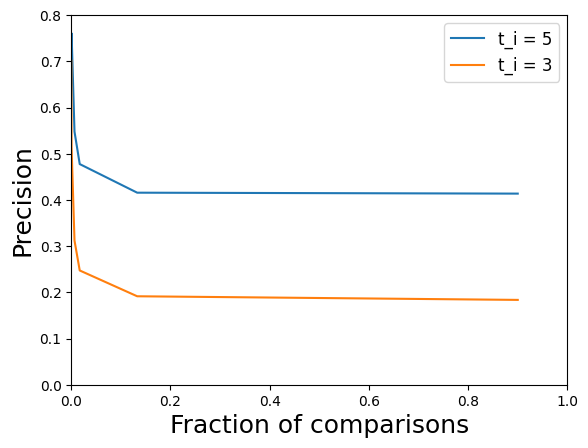

In [58]:
# Define the x-coordinates of the points
x = [1.4600000e+01 ,1.0455000e+02, 1.1666500e+03, 3.0614000e+03, 2.3878500e+04, 1.6175585e+05]
x = np.divide(x,179700)

PR_5 = [0.73388889 ,0.76062341, 0.54790984 ,0.47758657, 0.41566252 ,0.4136542 ]
RC_5 = [0.04651512, 0.22760039, 0.40775235, 0.43040765, 0.44017805 ,0.44017805]
F1_5 = [0.08748527, 0.35036231 ,0.46755334 ,0.45277141 ,0.42756916 ,0.42650415]


PR_3 = [0.70125  ,  0.51462058, 0.31212037 ,0.24730389, 0.1914559,  0.18360333]
RC_3 =[0.05285898 ,0.27003569, 0.64357448 ,0.76176748 ,0.89968151, 0.90899575]
F1_3 = [0.0983077 , 0.3542084,  0.42036996, 0.37338897, 0.31572437, 0.30550025]



# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, PR_5, label='t_i = 5')
ax.plot(x, PR_3, label='t_i = 3')

# Set limits for the x and y axes
plt.xlim(0, 1)
plt.ylim(0, 0.8)

# Add labels and title
plt.xlabel('Fraction of comparisons', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('')

plt.legend(fontsize='large')

# Show the plot
plt.show()

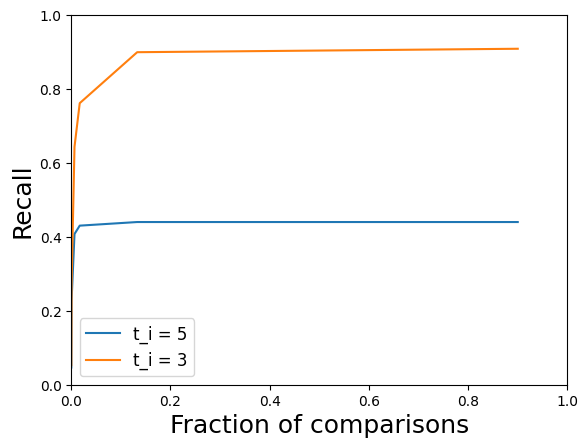

In [59]:
# Define the x-coordinates of the points
x = [1.4600000e+01 ,1.0455000e+02, 1.1666500e+03, 3.0614000e+03, 2.3878500e+04, 1.6175585e+05]
x = np.divide(x,179700)


PR_5 = [0.73388889 ,0.76062341, 0.54790984 ,0.47758657, 0.41566252 ,0.4136542 ]
RC_5 = [0.04651512, 0.22760039, 0.40775235, 0.43040765, 0.44017805 ,0.44017805]
F1_5 = [0.08748527, 0.35036231 ,0.46755334 ,0.45277141 ,0.42756916 ,0.42650415]


PR_3 = [0.70125  ,  0.51462058, 0.31212037 ,0.24730389, 0.1914559,  0.18360333]
RC_3 =[0.05285898 ,0.27003569, 0.64357448 ,0.76176748 ,0.89968151, 0.90899575]
F1_3 = [0.0983077 , 0.3542084,  0.42036996, 0.37338897, 0.31572437, 0.30550025]



# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, RC_5, label='t_i = 5')
ax.plot(x, RC_3, label='t_i = 3')

# Set limits for the x and y axes
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Fraction of comparisons', fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.title('')

plt.legend(fontsize='large')

# Show the plot
plt.show()

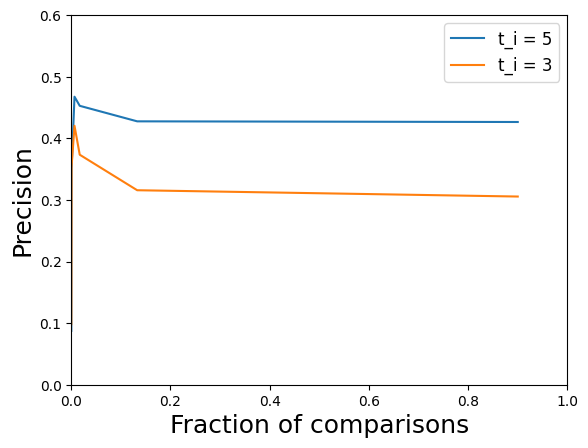

In [60]:
# Define the x-coordinates of the points
x = [1.4600000e+01 ,1.0455000e+02, 1.1666500e+03, 3.0614000e+03, 2.3878500e+04, 1.6175585e+05]
x = np.divide(x,179700)


PR_5 = [0.73388889 ,0.76062341, 0.54790984 ,0.47758657, 0.41566252 ,0.4136542 ]
RC_5 = [0.04651512, 0.22760039, 0.40775235, 0.43040765, 0.44017805 ,0.44017805]
F1_5 = [0.08748527, 0.35036231 ,0.46755334 ,0.45277141 ,0.42756916 ,0.42650415]


PR_3 = [0.70125  ,  0.51462058, 0.31212037 ,0.24730389, 0.1914559,  0.18360333]
RC_3 =[0.05285898 ,0.27003569, 0.64357448 ,0.76176748 ,0.89968151, 0.90899575]
F1_3 = [0.0983077 , 0.3542084,  0.42036996, 0.37338897, 0.31572437, 0.30550025]



# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, F1_5, label='t_i = 5')
ax.plot(x, F1_3, label='t_i = 3')

# Set limits for the x and y axes
plt.xlim(0, 1)
plt.ylim(0, 0.6)

# Add labels and title
plt.xlabel('Fraction of comparisons', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('')

plt.legend(fontsize='large')

# Show the plot
plt.show()

In [255]:
#RESULTS LSH
print(PC)
print(PQ)  
print(comparisons)
print(F1)

[0.06972914 0.29403681 0.71759199 0.85334794 0.98016245 1.        ]
[0.29265975 0.15379106 0.03271681 0.0154877  0.00226362 0.00034381]
[1.3200000e+01 1.0895000e+02 1.2440500e+03 3.1735000e+03 2.5537850e+04
 1.6328755e+05]
[0.11262438 0.20195363 0.06258042 0.03042324 0.00451681 0.00068738]


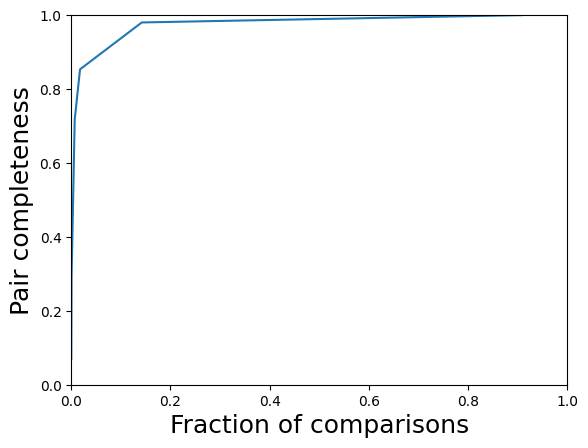

In [257]:
# Define the x-coordinates of the points
x = [1.3200000e+01 ,1.0895000e+02, 1.2440500e+03 ,3.1735000e+03, 2.5537850e+04, 1.6328755e+05]
x = np.divide(x,179700)

# Define the y-coordinates of the first line
PC = np.array([0.06972914 ,0.29403681 ,0.71759199, 0.85334794, 0.98016245, 1.        ])
PQ = np.array([0.29265975, 0.15379106, 0.03271681 ,0.0154877  ,0.00226362 ,0.00034381])
F1 = np.divide(2*PQ*PC,PQ+PC)


# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, PC)

# Set limits for the x and y axes
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Fraction of comparisons',  fontsize=18)
plt.ylabel('Pair completeness',  fontsize=18)
plt.title('')

# Show the plot
plt.show()

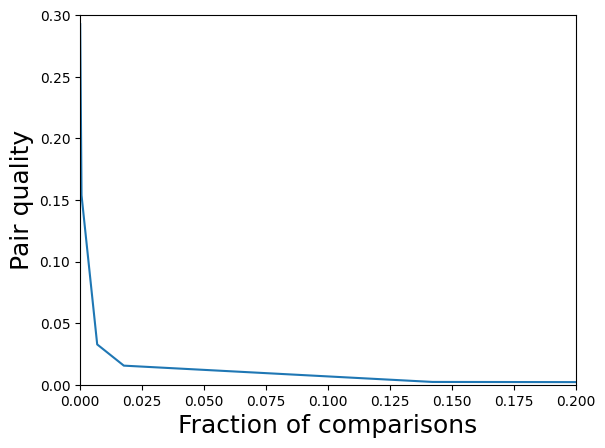

In [264]:
# Define the x-coordinates of the points
x = [1.3200000e+01 ,1.0895000e+02, 1.2440500e+03 ,3.1735000e+03, 2.5537850e+04, 1.6328755e+05]
x = np.divide(x,179700)

# Define the y-coordinates of the first line
PC = np.array([0.06972914 ,0.29403681 ,0.71759199, 0.85334794, 0.98016245, 1.        ])
PQ = np.array([0.29265975, 0.15379106, 0.03271681 ,0.0154877  ,0.00226362 ,0.00034381])
F1 = np.divide(2*PQ*PC,PQ+PC)


# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, PQ)

# Set limits for the x and y axes
plt.xlim(0, 0.2)
plt.ylim(0, 0.3)

# Add labels and title
plt.xlabel('Fraction of comparisons', fontsize=18)
plt.ylabel('Pair quality', fontsize=18)
plt.title('')

# Show the plot
plt.show()

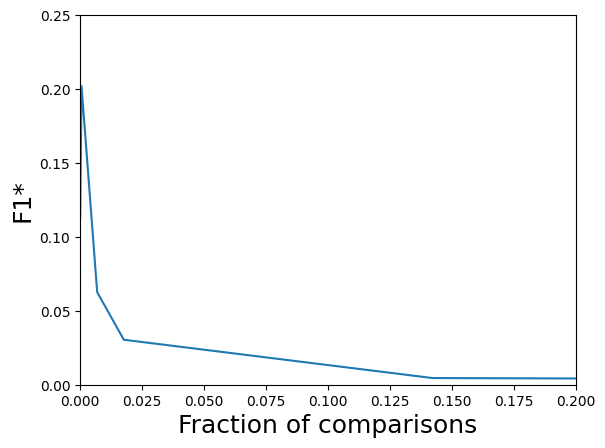

In [263]:
# Define the x-coordinates of the points
x = [1.3200000e+01 ,1.0895000e+02, 1.2440500e+03 ,3.1735000e+03, 2.5537850e+04, 1.6328755e+05]
x = np.divide(x,179700)

# Define the y-coordinates of the first line
PC = np.array([0.06972914 ,0.29403681 ,0.71759199, 0.85334794, 0.98016245, 1.        ])
PQ = np.array([0.29265975, 0.15379106, 0.03271681 ,0.0154877  ,0.00226362 ,0.00034381])
F1 = np.divide(2*PQ*PC,PQ+PC)


# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x, F1)

# Set limits for the x and y axes
plt.xlim(0, 0.2)
plt.ylim(0, 0.25)

# Add labels and title
plt.xlabel('Fraction of comparisons',  fontsize=18)
plt.ylabel('F1*',  fontsize=18)
plt.title('')

# Show the plot
plt.show()

In [25]:
#FINAL RESULTS SPLITTED KEYS
print(truePos)
print(falsePos)  
print(falseNeg)
print(PR)
print(RC)
print(F1)
print(comparisons)

[ 6. 18. 27. 30. 30.]
[ 0.  5.  9. 10. 10.]
[45. 33. 24. 21. 21.]
[0.80105159 0.80286167 0.79286318 0.7706854  0.77167221]
[0.08604962 0.32330178 0.52946103 0.60646942 0.61019247]
[0.15540545 0.46097502 0.63492773 0.67878661 0.68149737]
[2.145000e+01 1.599000e+02 1.930900e+03 4.164605e+04 1.690113e+05]


In [ ]:
bucket_dict1 = {}
    for t,r in enumerate(test[:,3]):
        rlower = r.lower()
        if rlower in bucket_dict1:
            bucket_dict1[rlower].append(t)
        else:
            bucket_dict1[rlower] = [t]
    listB = set()
    for g in bucket_dict1.values():
        for v in range(len(g)):
            for k in range(v+1,len(g)):
                listB.add((g[v],g[k]))